# 데이터 관련

In [1]:
# import modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import models, transforms

import matplotlib.pyplot as plt
import random
import time
import os

import numpy as np

###  Google Drive Mount

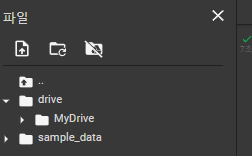

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Unzip dataset
- 구글 드라이브에 데이터를 저장할 시 I/O 병목으로 인해 train 속도가 느릴 수 있습니다.
- 코랩의 content 디렉토리 아래에 데이터의 압축을 풀어 사용하시기 바랍니다

In [ ]:
# unzip train, valid dataset
# target 을 정하지 않으면 google drive 내의 content 드라이브에 위치시킴
# 런타임을 다시 시작할 때 마다 unzip 을 새로 해주어야 함.
!unzip /content/gdrive/MyDrive/2023_EEE4178_project/train.zip
!unzip /content/gdrive/MyDrive/2023_EEE4178_project/valid.zip
# !unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_test.zip

### Custom dataset & dataloader

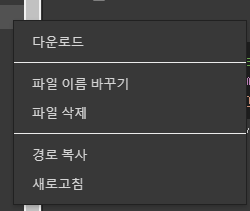

In [4]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

class MyDataset(Dataset):
    def __init__(self, npy_dir, label_dict=None):
        self.dir_path = npy_dir
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.transpose(0, 1)),
            transforms.Lambda(lambda x: TF.rotate(x, -90))
        ])
        self.npy_path = glob.glob(os.path.join(npy_dir, '*', '*.npy'))
        self.label_dict = label_dict or self.create_label_dict()

    def create_label_dict(self):
        label_dict = {}
        for path in self.npy_path:
            label_name = os.path.basename(os.path.dirname(path))
            if label_name not in label_dict:
                label_dict[label_name] = len(label_dict)
        return label_dict

    def __getitem__(self, index):
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)

        image = data['image']
        image = self.to_tensor(image)
        image = TF.hflip(image)

        label_name = os.path.basename(os.path.dirname(single_data_path))
        label = self.label_dict[label_name]
        label = torch.tensor(label, dtype=torch.long)

        return (image, label)

    def __len__(self):
        return len(self.npy_path)

label_dict = {
    '30': 0, '31': 1, '32': 2, '33': 3, '34': 4, '35': 5, '36': 6, '37': 7, '38': 8, '39': 9,
    '41': 10, '42': 11, '43': 12, '44': 13, '45': 14, '46': 15, '47': 16, '48': 17, '49': 18,
    '4a': 19, '4b': 20, '4c': 21, '4d': 22, '4e': 23, '50': 24, '51': 25, '52': 26, '53': 27,
    '54': 28, '55': 29, '56': 30, '57': 31, '58': 32, '59': 33, '5a': 34, '61': 35, '62': 36,
    '64': 37, '65': 38, '66': 39, '67': 40, '68': 41, '69': 42, '6a': 43, '6d': 44, '6e': 45,
    '6f': 46, '71': 47, '72': 48, '74': 49, '75': 50, '79': 51,
}



# unzip 한 디렉토리 있는 path 그대로 넣어야, 디렉토리 옆 점 3개 누르면 '경로 복사' 있음 - 위의 사진 참조
train_data = MyDataset("/content/train", label_dict)
valid_data = MyDataset("/content/valid", label_dict)

print(len(train_data))
print(len(valid_data))

41600
15600


In [5]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           shuffle=True)



# check dataloader
image,label = next(iter(valid_loader))
print(image.shape)
print(label.shape)

torch.Size([50, 1, 100, 100])
torch.Size([50])


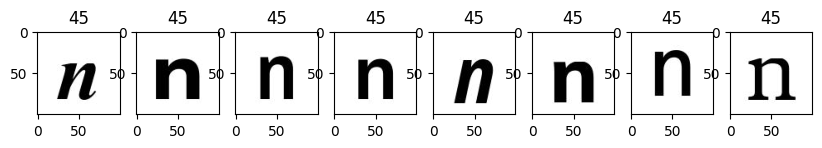

In [6]:
# visualize data
# image_show function : num 수 만큼 dataset 내의 data를 보여주는 함수
def image_show(dataset, num):
  fig = plt.figure(figsize=(10,10))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i+12200][0].squeeze(), cmap="gray")
    plt.title(dataset[i+12200][1].item())  # .item()을 사용하여 텐서에서 숫자로 변환

image_show(train_data, 8)

#학습 환경 관련


### Check GPU Configuration

In [7]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Mon Dec 11 10:19:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Fix seed
42로 Seed를 고정하여 사용하시기 바랍니다.

In [8]:
# FIX SEED
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

학습 도중 valid dataloader 를 이용해서 valid 성능을 측정할 때, 기존의 실습 때 사용하였던 아래와 같은 방식은 batch size 가 valid dataset 길이 (15600) 의 약수일 때만 정확합니다.

In [ ]:
print('Accuracy of the last_model network on the {} valid images: {} %'.\
          format(len(valid_loader)*batch_size, 100 * correct / (len(valid_loader)*batch_size)))

Torch dataloader 는 기본적으로 마지막에 남는 데이터를 그대로 전달하기 때문에, 위와 같은 방식으로 하면 valid accuracy 가 더 낮게 나옵니다.

이 경우에 아래 방식으로 print 를 하면 정확힌 valid accuracy 값을 확인하실 수 있습니다.

In [ ]:
print('Accuracy of the last_model network on the {} valid images: {} %'.\
       format(len(valid_data), 100 * correct / len(valid_data)))

#Train 소요 시간 측정

In [ ]:
import time
start = time.time() # Train 시작 시간 정보 저장
##원하는 동작 수행##
end = time.time() # Train 종료 시간 정보 저장
duration = end - start # 종료 시간 - 시작 시간
print("Training takes {:.2f}minutes".format(duration/60)) #초 단위로 저장되므로, 60으로 나누어 분으로 표시

다음과 같이 데코레이터를 작성하여 사용할 수도 있습니다. (초로 표현되어 있으나, 분으로 수정하셔서 사용하시면 됩니다.)

In [ ]:
import time


def elapsed(f):
    def wrap(*args):
        start_r = time.perf_counter()
        start_p = time.process_time()
        # 함수 실행
        ret = f(*args)
        end_r = time.perf_counter()
        end_p = time.process_time()
        elapsed_r = end_r - start_r
        elapsed_p = end_p - start_p

        print(f'{f.__name__} elapsed: {elapsed_r:.6f}sec (real) / {elapsed_p:.6f}sec (cpu)')
        return ret
   # 함수 객체를 return
    return wrap



@elapsed
def comp_flat(l):
    return [item for sublist in m for item in sublist]

@elapsed
def sum_flat(l):
    return sum(l,[])


if __name__ == "__main__":
    m = [
        [1,2,3],
        [4,5,6],
        [7,8,9]]

    sum_flat(m)
    comp_flat(m)